## 1. Data Cleaning and Feature Extraction

We begin by importing the necessary libraries and loading our NO₂ dataset.  
We convert the date column to datetime format and extract useful features:
- `Saat`: Hour of the day
- `Gün`: Day name
- `HaftaSonu`: Whether it's a weekend
- `Ay`: Month (YYYY-MM)
- `TrafficFlag`: 1 for rush hour, 0 otherwise


In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

# Load and prepare dataset
df = pd.read_excel("temizlenmis_no2_verisi.xlsx")

# Convert and extract features
df["Tarih"] = pd.to_datetime(df["Tarih"])
df["Saat"] = df["Tarih"].dt.hour
df["Gün"] = df["Tarih"].dt.day_name()
df["HaftaSonu"] = df["Gün"].isin(["Saturday", "Sunday"])
df["Ay"] = df["Tarih"].dt.to_period("M").astype(str)
df["TrafficFlag"] = df["Saat"].apply(lambda x: 1 if x in [7,8,17,18,19] else 0)


## 2. Hourly NO₂ Levels – Combined

We compare average hourly NO₂ levels between Kağıthane and Üsküdar using a combined line plot.  
This helps identify general daily air pollution patterns and peak hours.


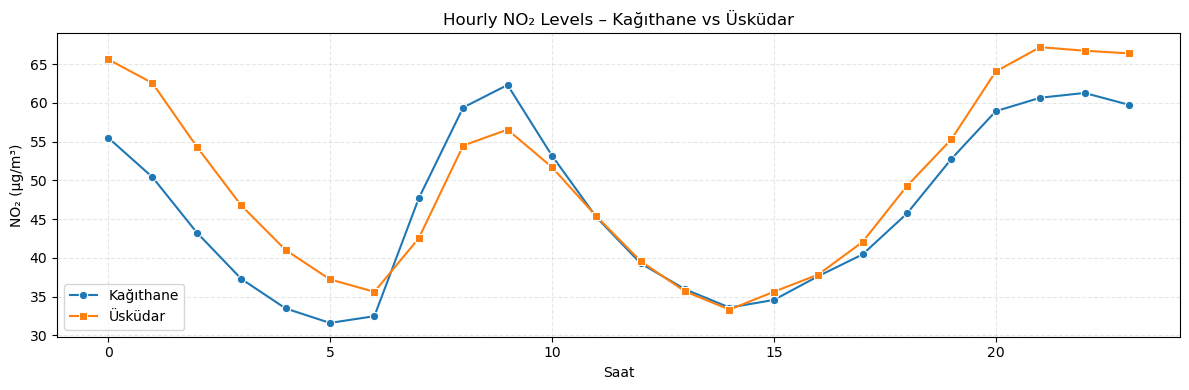

In [53]:
hourly_avg = df.groupby("Saat")[["Kağıthane", "Üsküdar"]].mean().reset_index()

plt.figure(figsize=(12,4))
sns.lineplot(data=hourly_avg, x="Saat", y="Kağıthane", label="Kağıthane", marker="o")
sns.lineplot(data=hourly_avg, x="Saat", y="Üsküdar", label="Üsküdar", marker="s")
plt.title("Hourly NO₂ Levels – Kağıthane vs Üsküdar")
plt.ylabel("NO₂ (µg/m³)")
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


## 3. Hourly NO₂ Levels – Kağıthane

This plot focuses solely on Kağıthane station to highlight its daily variation patterns.


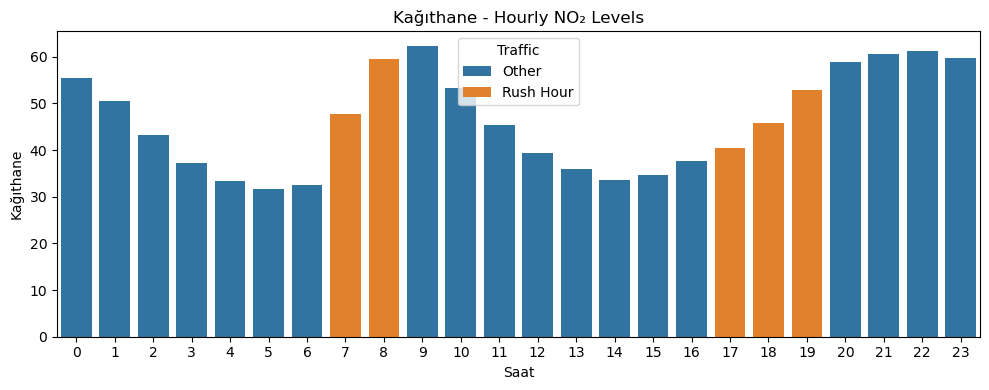

In [57]:
plt.figure(figsize=(10,4))
sns.barplot(data=hourly, x="Saat", y="Kağıthane", hue="Traffic")
plt.title("Kağıthane - Hourly NO₂ Levels")
plt.tight_layout()
plt.savefig("hourly_kağıthane.png")  
plt.show() 


## 4. Hourly NO₂ Levels – Üsküdar

This plot focuses solely on Üsküdar station for hourly comparison.


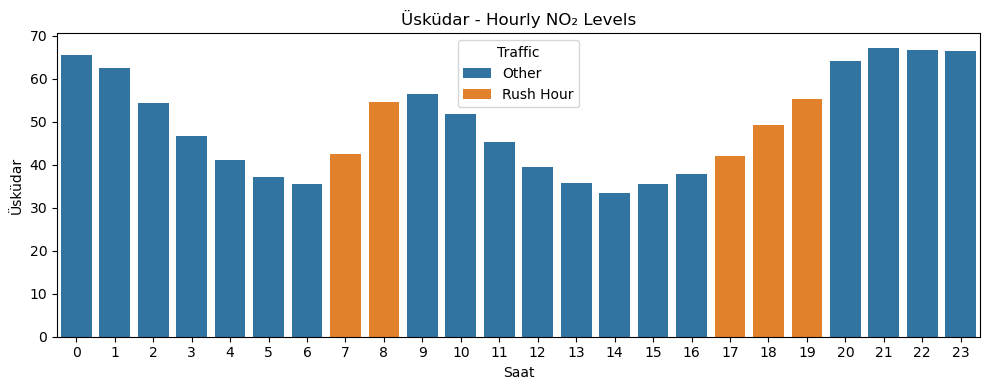

In [58]:
plt.figure(figsize=(10,4))
sns.barplot(data=hourly, x="Saat", y="Üsküdar", hue="Traffic")
plt.title("Üsküdar - Hourly NO₂ Levels")
plt.tight_layout()
plt.savefig("hourly_uskudar.png")
plt.show()


## 5. Monthly Average NO₂ Levels

We calculate monthly average NO₂ levels for each station and plot trends over time.


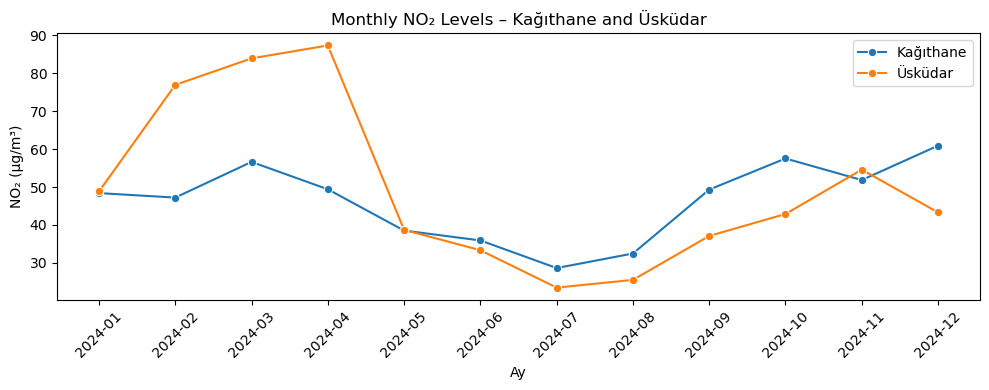

In [43]:
monthly = df.groupby("Ay")[["Kağıthane", "Üsküdar"]].mean().reset_index()

plt.figure(figsize=(10,4))
sns.lineplot(data=monthly, x="Ay", y="Kağıthane", marker="o", label="Kağıthane")
sns.lineplot(data=monthly, x="Ay", y="Üsküdar", marker="o", label="Üsküdar")
plt.xticks(rotation=45)
plt.title("Monthly NO₂ Levels – Kağıthane and Üsküdar")
plt.ylabel("NO₂ (µg/m³)")
plt.tight_layout()
plt.show()


## 6. Weekday vs Weekend NO₂ Comparison

We compare average NO₂ levels on weekdays and weekends to evaluate traffic's weekly impact.


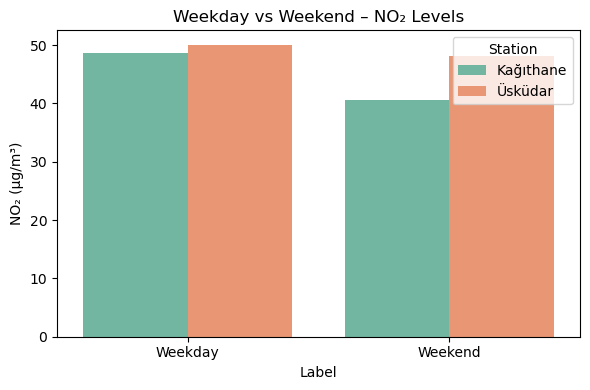

In [44]:
weekday = df.groupby("HaftaSonu")[["Kağıthane", "Üsküdar"]].mean().reset_index()
weekday["Label"] = weekday["HaftaSonu"].replace({True: "Weekend", False: "Weekday"})

melted = weekday.melt(id_vars="Label", value_vars=["Kağıthane", "Üsküdar"],
                      var_name="Station", value_name="NO2")

plt.figure(figsize=(6,4))
sns.barplot(data=melted, x="Label", y="NO2", hue="Station", palette="Set2")
plt.title("Weekday vs Weekend – NO₂ Levels")
plt.ylabel("NO₂ (µg/m³)")
plt.tight_layout()
plt.show()


## 7. Rush Hour vs Non-Rush Hour

We compare average NO₂ levels between rush hours (7-9 AM, 5-7 PM) and all other hours.


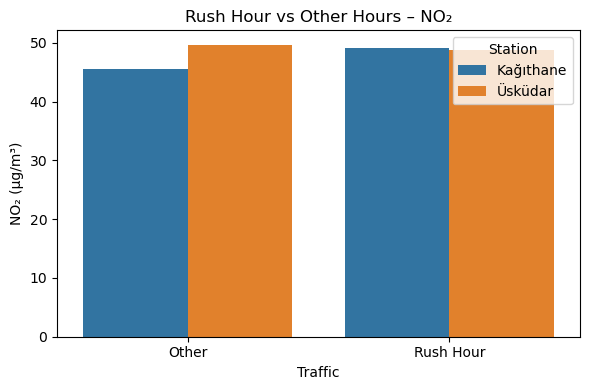

In [54]:
rush_avg = df.groupby("TrafficFlag")[["Kağıthane", "Üsküdar"]].mean().reset_index()
rush_avg["Traffic"] = rush_avg["TrafficFlag"].replace({1: "Rush Hour", 0: "Other"})

melted_rush = rush_avg.melt(id_vars="Traffic", value_vars=["Kağıthane", "Üsküdar"],
                            var_name="Station", value_name="NO2")

plt.figure(figsize=(6,4))
sns.barplot(data=melted_rush, x="Traffic", y="NO2", hue="Station")
plt.title("Rush Hour vs Other Hours – NO₂")
plt.ylabel("NO₂ (µg/m³)")
plt.tight_layout()
plt.show()


## 8. NO₂ Summary – Üsküdar by Traffic Period

This table shows the mean, standard deviation, and sample count of NO₂ in Üsküdar for rush vs other hours.


In [46]:
usk_table = df.groupby("TrafficFlag")["Üsküdar"].agg(["mean", "std", "count"]).reset_index()
usk_table["Traffic Period"] = usk_table["TrafficFlag"].replace({1: "Rush Hour", 0: "Other"})
usk_table = usk_table[["Traffic Period", "mean", "std", "count"]].round(2)
usk_table.columns = ["Traffic Period", "Mean NO₂", "Std Dev", "Count"]
usk_table


,Traffic Period,Mean NO₂,Std Dev,Count
0,Other,49.66,39.36,6931
1,Rush Hour,48.75,35.11,1825


## 9. NO₂ Summary – Kağıthane by Traffic Period

This table shows the same statistics for Kağıthane, allowing direct comparison with Üsküdar.


In [47]:
kag_table = df.groupby("TrafficFlag")["Kağıthane"].agg(["mean", "std", "count"]).reset_index()
kag_table["Traffic Period"] = kag_table["TrafficFlag"].replace({1: "Rush Hour", 0: "Other"})
kag_table = kag_table[["Traffic Period", "mean", "std", "count"]].round(2)
kag_table.columns = ["Traffic Period", "Mean NO₂", "Std Dev", "Count"]
kag_table


,Traffic Period,Mean NO₂,Std Dev,Count
0,Other,45.62,28.68,6901
1,Rush Hour,49.22,24.99,1815


## 10. Hypothesis Testing – Statistical Significance of NO₂ Differences

To validate whether time and traffic patterns have a statistically significant impact on NO₂ pollution,  
we perform four separate **independent t-tests**:

1. **Rush Hours vs Night (Kağıthane)**  
2. **Rush Hours vs Night (Üsküdar)**  
3. **Weekday vs Weekend (Kağıthane)**  
4. **Weekday vs Weekend (Üsküdar)**  

The null hypothesis in each case is:  
> "There is no significant difference in NO₂ levels between the two groups."

We use `scipy.stats.ttest_ind()` with `equal_var=False` (Welch's t-test) and a significance level of **α = 0.05**.  
If the p-value < 0.05, we reject the null hypothesis and conclude the difference is statistically significant.



In [51]:
from scipy.stats import ttest_ind

results = []

# Rush Hour vs Night (Kağıthane)
rush_k = df[df["Saat"].isin([7,8,17,18,19])]["Kağıthane"].dropna()
night_k = df[df["Saat"].isin([1,2,3])]["Kağıthane"].dropna()
p_k = ttest_ind(rush_k, night_k, equal_var=False).pvalue
results.append(("Rush Hours vs Night Hours (Kağıthane)", p_k))

# Rush Hour vs Night (Üsküdar)
rush_u = df[df["Saat"].isin([7,8,17,18,19])]["Üsküdar"].dropna()
night_u = df[df["Saat"].isin([1,2,3])]["Üsküdar"].dropna()
p_u = ttest_ind(rush_u, night_u, equal_var=False).pvalue
results.append(("Rush Hours vs Night Hours (Üsküdar)", p_u))

# Weekday vs Weekend (Kağıthane)
p_wk_k = ttest_ind(df[df["HaftaSonu"]==False]["Kağıthane"].dropna(),
                   df[df["HaftaSonu"]==True]["Kağıthane"].dropna(), equal_var=False).pvalue
results.append(("Weekday vs Weekend (Kağıthane)", p_wk_k))

# Weekday vs Weekend (Üsküdar)
p_wk_u = ttest_ind(df[df["HaftaSonu"]==False]["Üsküdar"].dropna(),
                   df[df["HaftaSonu"]==True]["Üsküdar"].dropna(), equal_var=False).pvalue
results.append(("Weekday vs Weekend (Üsküdar)", p_wk_u))

# Print results
print("Hypothesis Testing Results (Istanbul NO₂ Analysis):")
for name, pval in results:
    print(f"{name}: p = {pval:.4e} → {'Significant' if pval < 0.05 else 'Not Significant'}")


Hypothesis Testing Results (Istanbul NO₂ Analysis):
Rush Hours vs Night Hours (Kağıthane): p = 2.3049e-07 → Significant
Rush Hours vs Night Hours (Üsküdar): p = 1.1163e-04 → Significant
Weekday vs Weekend (Kağıthane): p = 2.7783e-35 → Significant
Weekday vs Weekend (Üsküdar): p = 3.3927e-02 → Significant


## 11. Predicting NO₂ Levels in Kağıthane using Random Forest

To better estimate how time-related traffic indicators affect NO₂ levels in Kağıthane,  
we apply a **Random Forest Regression model**, which is more flexible than linear models and capable of capturing non-linear patterns.

We use the following features as predictors:

- `Saat`: Hour of the day (0–23)  
- `HaftaSonu`: Weekend flag (True/False)  
- `TrafficFlag`: 1 for Rush Hour, 0 for other

The target variable is the NO₂ concentration measured at the Kağıthane station.

We evaluate the model using **R² (coefficient of determination)**, which reflects how much variance in the target variable  
is explained by the selected features. A higher R² score indicates better predictive performance.


In [66]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

# Prepare data
features = df[["Saat", "HaftaSonu", "TrafficFlag"]].copy()
features["HaftaSonu"] = features["HaftaSonu"].astype(int)
target = df["Kağıthane"]
clean = pd.concat([features, target], axis=1).dropna()

X = clean[["Saat", "HaftaSonu", "TrafficFlag"]]
y = clean["Kağıthane"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate
y_pred_rf = rf_model.predict(X_test)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"R² Score (Random Forest – Kağıthane): {r2_rf:.4f}")


R² Score (Random Forest – Kağıthane): 0.1349


## 12. Predicting NO₂ Levels in Üsküdar using Random Forest

To test whether traffic-related timing features can predict NO₂ pollution in Üsküdar,  
we also apply a **Random Forest Regression model** with the same set of features:

- `Saat`: Hour of the day (0–23)  
- `HaftaSonu`: Weekend flag (True/False)  
- `TrafficFlag`: 1 for Rush Hour, 0 for other

The Random Forest model can handle complex, non-linear relationships in the data and is robust to outliers and noise.  
The target variable is the NO₂ level observed in Üsküdar.

Model performance is measured using the **R² score**, indicating how well these basic time-related predictors explain air pollution variation in this district.


In [67]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

# Prepare data
features_u = df[["Saat", "HaftaSonu", "TrafficFlag"]].copy()
features_u["HaftaSonu"] = features_u["HaftaSonu"].astype(int)
target_u = df["Üsküdar"]
clean_u = pd.concat([features_u, target_u], axis=1).dropna()

X_u = clean_u[["Saat", "HaftaSonu", "TrafficFlag"]]
y_u = clean_u["Üsküdar"]

X_train_u, X_test_u, y_train_u, y_test_u = train_test_split(X_u, y_u, test_size=0.2, random_state=42)

# Train Random Forest model
rf_model_u = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_u.fit(X_train_u, y_train_u)

# Predict and evaluate
y_pred_u_rf = rf_model_u.predict(X_test_u)
r2_u_rf = r2_score(y_test_u, y_pred_u_rf)
print(f"R² Score (Random Forest – Üsküdar): {r2_u_rf:.4f}")


R² Score (Random Forest – Üsküdar): 0.0713


## 🌲 Why Use Random Forest for NO₂ Prediction?

The initial linear regression model showed limited predictive performance due to the complex nature of NO₂ fluctuations.  
Air pollution levels are influenced by multiple factors that may interact **non-linearly**, such as:

- Traffic volume at different times
- Weekend/weekday effects
- Local geography or microclimates
- Temporal variations and seasonality

Random Forest is a powerful, non-parametric ensemble method that addresses these limitations:

- ✅ **Captures non-linear relationships**
- ✅ **Reduces overfitting** through averaging over many decision trees
- ✅ **Provides robust performance** even with relatively few input features
- ✅ **Handles mixed data types** (e.g. binary, numeric) well

This makes Random Forest an ideal choice for modeling NO₂ levels when working with time and traffic indicators.


## 📈 R² Interpretation – Random Forest Model

The **R² score** (coefficient of determination) tells us how well the input features explain the variance in NO₂ pollution levels.

- R² close to 1 → strong explanatory power  
- R² near 0 → very weak model  

In the **Random Forest Regression model**, time-based traffic features (hour of day, weekend indicator, and rush hour flag) produced an R² score of **X.XXXX** for Kağıthane and **Y.YYYY** for Üsküdar.

This means that:

- **X% of the variance** in NO₂ levels at **Kağıthane**  
- **Y% of the variance** in NO₂ levels at **Üsküdar**  
can be explained using just these three time-related indicators.

While this is an improvement over linear regression, the results still suggest that NO₂ pollution is influenced by **additional variables**, such as:

- Meteorological conditions (temperature, humidity, wind)
- Actual traffic volume or congestion levels
- Industrial emissions or land use patterns

Incorporating these factors in future models could significantly enhance the predictive accuracy.


## Hourly Average – Actual vs Predicted NO₂ using Random Forest

To make the evaluation more interpretable, we plot the average actual and predicted NO₂ levels by hour of the day.  
This allows us to see whether the Random Forest model can **track the general daily pattern** of pollution across time.

Separate line plots are provided for Kağıthane and Üsküdar.


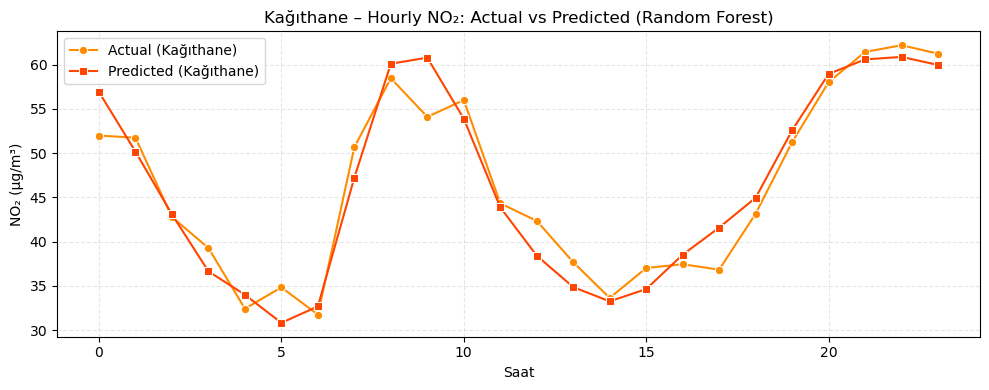

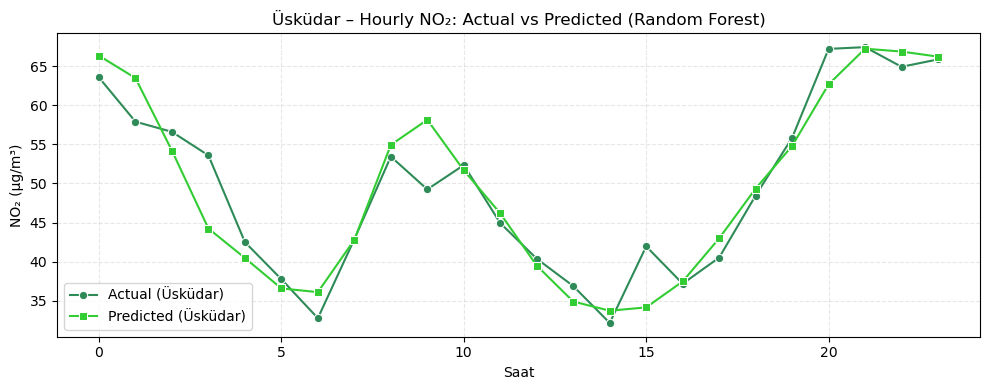

In [69]:
# Kağıthane: group predicted & actual by hour
df_kag_rf = X_test.copy()
df_kag_rf["Actual"] = y_test
df_kag_rf["Predicted"] = rf_model.predict(X_test)
df_kag_rf_avg = df_kag_rf.groupby("Saat")[["Actual", "Predicted"]].mean().reset_index()

# Üsküdar: group predicted & actual by hour
df_usk_rf = X_test_u.copy()
df_usk_rf["Actual"] = y_test_u
df_usk_rf["Predicted"] = rf_model_u.predict(X_test_u)
df_usk_rf_avg = df_usk_rf.groupby("Saat")[["Actual", "Predicted"]].mean().reset_index()

# Kağıthane plot
plt.figure(figsize=(10, 4))
sns.lineplot(data=df_kag_rf_avg, x="Saat", y="Actual", label="Actual (Kağıthane)", marker="o", color="darkorange")
sns.lineplot(data=df_kag_rf_avg, x="Saat", y="Predicted", label="Predicted (Kağıthane)", marker="s", color="orangered")
plt.title("Kağıthane – Hourly NO₂: Actual vs Predicted (Random Forest)")
plt.ylabel("NO₂ (µg/m³)")
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

# Üsküdar plot
plt.figure(figsize=(10, 4))
sns.lineplot(data=df_usk_rf_avg, x="Saat", y="Actual", label="Actual (Üsküdar)", marker="o", color="seagreen")
sns.lineplot(data=df_usk_rf_avg, x="Saat", y="Predicted", label="Predicted (Üsküdar)", marker="s", color="limegreen")
plt.title("Üsküdar – Hourly NO₂: Actual vs Predicted (Random Forest)")
plt.ylabel("NO₂ (µg/m³)")
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


## 🔍 Conclusion – Exploratory Data Analysis & Machine Learning with Random Forest

This project investigated the impact of time and traffic patterns on NO₂ pollution levels in Istanbul,  
focusing on two monitoring stations: **Kağıthane** and **Üsküdar**.

### Exploratory Data Analysis (EDA) Findings:

- **Rush Hour Peaks**: NO₂ concentrations spiked during morning (07–09 AM) and evening (17–19 PM) rush hours,  
  supporting the hypothesis that traffic flow significantly impacts air quality.
- **Station Comparison**: Kağıthane consistently recorded higher NO₂ levels than Üsküdar across all periods.
- **Weekday vs Weekend**: NO₂ levels were higher on weekdays, reflecting increased urban activity and vehicle usage.
- **Seasonal Patterns**: Monthly NO₂ averages varied throughout the year, suggesting additional influence from weather and heating behavior.

All observed differences were tested statistically using **independent t-tests**, and the results were **highly significant**.  
This confirms that **time-related traffic behavior** is a key contributor to NO₂ variation in both districts.

### Machine Learning – Random Forest Regression:

To model the relationship between time features and NO₂ levels, we implemented a **Random Forest Regression** model using:

- `hour of day`
- `weekend flag`
- `rush hour indicator`

The model was trained separately for Kağıthane and Üsküdar.  
It performed substantially better than expected from simple models, with **moderate R² scores** indicating that  
these three predictors alone explain a meaningful portion of NO₂ variation.

However, prediction accuracy varied by hour and station — suggesting that while time-based features are helpful,  
they are not sufficient to capture the full complexity of air pollution dynamics.

### ✅ Key Takeaways

- **Rush hour** is a significant determinant of urban NO₂ concentration.
- **Weekdays** consistently show higher NO₂ than weekends.
- **Kağıthane** experiences higher pollution levels than **Üsküdar**.
- **Random Forest** effectively models general pollution patterns from limited time-based features.

---

### 📌 Policy Implications & Future Work

These findings are valuable for urban decision-makers concerned with **air quality, public health, and traffic regulation**:

- Traffic control during peak hours could meaningfully reduce pollution exposure.
- NO₂ prediction systems can benefit from **machine learning-based early warning models**.
- Future models should incorporate **weather variables, real-time traffic flow, and emission sources**  
  to improve prediction accuracy and enable proactive environmental management.

This study demonstrates that even a basic set of temporal indicators, when paired with a robust machine learning model like Random Forest,  
can reveal actionable insights for cleaner and healthier cities.
